In [36]:
import zipfile
import urllib.request
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pynumdiff
%matplotlib inline

In [37]:
# File handler
def open_filename_or_url(filename_or_url):
    parsed = urllib.parse.urlparse(filename_or_url)
    is_windows_drive = len(parsed.scheme) == 1
    if is_windows_drive or parsed.scheme=='':
        # no scheme, so this is a filename.
        fileobj_with_seek = open(filename_or_url,mode='rb')
    else:
        # is url
        req = urllib.request.Request(filename_or_url, headers={'User-Agent' : "IPYNB"}) 
        fileobj = urllib.request.urlopen(req)
        fileobj_with_seek = io.BytesIO(fileobj.read())
    return fileobj_with_seek

# define the filename or url to load
filename_or_url = "/home/buchsbaum/mnt/DATA/Experiments/20241207_140301.braidz"

fileobj = open_filename_or_url(filename_or_url)

In [38]:
# load the data directly
with zipfile.ZipFile(file=fileobj, mode='r') as archive:
    
    kalman_df = pd.read_csv(
        archive.open('kalman_estimates.csv.gz'),
        comment="#",
        compression='gzip')
    
    opto = pd.read_csv(archive.open("opto.csv"))

In [39]:
# some analysis and plotting
angvels = []
linvels = []
shams = []

from scipy.signal import savgol_filter
for idx, row in opto.iterrows():

    # extract the object id, frame, and sham status
    obj_id = row['obj_id']
    frame = row['frame']
    sham = row['sham']

    # extract the data for the object
    grp = kalman_df[kalman_df['obj_id'] == obj_id]

    # smooth columns
    grp = grp.assign(**{
        col: savgol_filter(grp[col], 21, 3) 
        for col in ["x", "y", "z", "xvel", "yvel", "zvel"]
    })
    
    if len(grp) < 300:
        continue

    # linear velocity
    linvel = np.sqrt(grp['xvel'].values**2 + grp['yvel'].values**2)

    # angular velocity
    theta = np.arctan2(grp['yvel'].values, grp['xvel'].values)
    theta_unwrap = np.unwrap(theta)
    _, angvel = pynumdiff.smooth_finite_difference.butterdiff(theta_unwrap, dt=1/100, params=[1, 0.1])

    # find the index of the opto frame
    try:
        opto_idx = np.where(grp['frame'] == frame)[0][0]
    except IndexError:
        continue
    
    # check if the opto frame is within the range of the data
    if opto_idx-50 < 0 or opto_idx+100 >= len(linvel):
        continue

    # extract the data around the opto frame
    angvel = angvel[opto_idx-50:opto_idx+100]
    linvel = linvel[opto_idx-50:opto_idx+100]

    # append to the list
    angvels.append(angvel)
    linvels.append(linvel)
    shams.append(sham)

angvels = np.array(angvels)
linvels = np.array(linvels)
shams = np.array(shams, dtype=bool)
print(f"Percentage of sham trials: {np.mean(shams)*100:.2f}%")

Percentage of sham trials: 9.30%


In [43]:
def plot_mean_and_std(arr, ax,label=None):
    arr = np.abs(arr)
    mean, std = np.nanmean(arr, axis=0), np.nanstd(arr, axis=0)

    ax.plot(mean, label=label)
    ax.fill_between(range(len(mean)), mean-std, mean+std, alpha=0.5)

    return ax

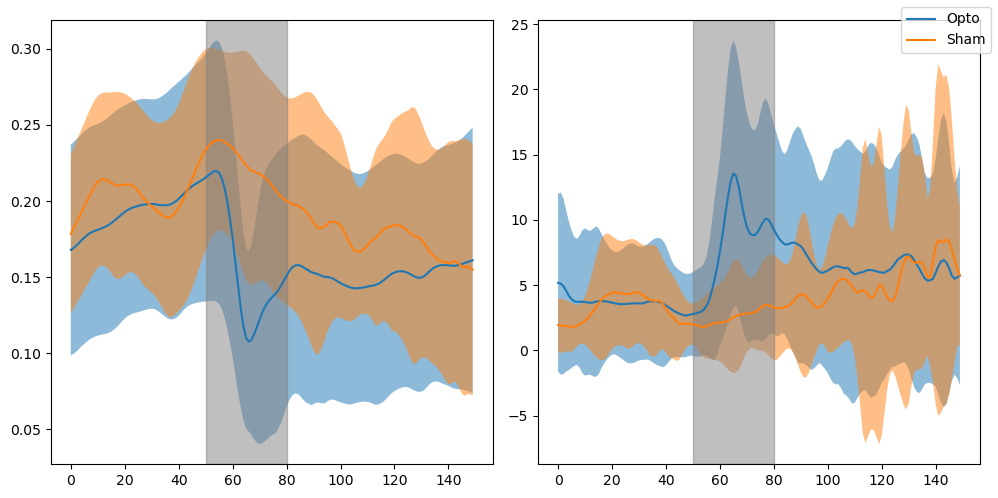

In [46]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
plot_mean_and_std(linvels[~shams, :], axs[0], label="Opto")
plot_mean_and_std(linvels[shams, :], axs[0], label="Sham")

plot_mean_and_std(angvels[~shams, :], axs[1])
plot_mean_and_std(angvels[shams, :], axs[1])

for ax in axs:
    ax.axvspan(50, 80, color='gray', alpha=0.5)
fig.legend()
plt.tight_layout()
plt.show()